In [1]:
from tvDatafeed import TvDatafeed, Interval
import mplfinance as mpf
import pandas as pd
import ta  # module for technical indicators
import ta.momentum
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [51]:
import pandas as pd
from tvDatafeed import TvDatafeed, Interval

symbol = "AMD"
exchange = "NASDAQ"
interval = Interval.in_1_minute
n_bars = 5000
tv = TvDatafeed()

df = tv.get_hist(symbol=symbol, exchange=exchange, interval=interval, n_bars=n_bars)
df = df.drop(columns=['symbol'])

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(series, short=12, long=26, signal=9):
    ema_short = series.ewm(span=short, adjust=False).mean()
    ema_long = series.ewm(span=long, adjust=False).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    return macd_line, signal_line

def compute_bollinger_bands(series, window=20, num_std=2):
    sma = series.rolling(window=window).mean()
    std_dev = series.rolling(window=window).std()
    upper_band = sma + (num_std * std_dev)
    lower_band = sma - (num_std * std_dev)
    return sma, upper_band, lower_band

def compute_features(df):
    # Compute Bollinger Bands
    df['SMA_20'], df['Bollinger_Upper'], df['Bollinger_Lower'] = compute_bollinger_bands(df['close'])
    df['SMA_10'] = df['close'].rolling(10).mean()
    df['SMA_5'] = df['close'].rolling(5).mean()

    # Feature Engineering for SMA
    df['SMA_5_Distance'] = (df['SMA_5'] - df['close']) / df['close']
    df['SMA_10_Distance'] = (df['SMA_10'] - df['close']) / df['close']
    df['SMA_Crossover'] = (df['SMA_5'] - df['SMA_10']) / df['close']

    # Calculate Volume features
    df['Volume_MA'] = df['volume'].rolling(window=50).mean()
    df['Volume_Spike'] = df['volume'] / df['Volume_MA']
    df['MACD'] = df['close'].ewm(span=12).mean() - df['close'].ewm(span=26).mean()

    # Normalized MACD
    df['Normalized_MACD'] = df['MACD'] / (df['MACD'].ewm(span=9, adjust=False).mean())

    # Normalized Bollinger Bands
    df['Normalized_BB'] = (df['close'] - df['Bollinger_Lower']) / (df['Bollinger_Upper'] - df['Bollinger_Lower'])

    # Rolling volatility (standard deviation of returns)
    df['Volatility_10_Days'] = df['close'].pct_change().rolling(window=10).std() * 100
    df['Volatility_20_Days'] = df['close'].pct_change().rolling(window=20).std() * 100

    # Target Value
    df['Mean_5_Days_Ahead'] = df['close'].shift(-10).rolling(window=10, min_periods=1).mean()
    df['Target'] = (df['Mean_5_Days_Ahead'] - df['close']) / df['close'] * 100
    #df['Target'] = (df['close'].shift(-5) - df['close']) / df['close'] * 100

    # Drop raw unbounded features
    df = df.drop(columns=['SMA_10', 'SMA_5'])

    return df


# Compute the features
df = compute_features(df)

# Drop unnecessary columns
df = df.drop(columns=['open', 'close', 'high', 'low'])

# Drop rows with missing values
df = df.dropna()


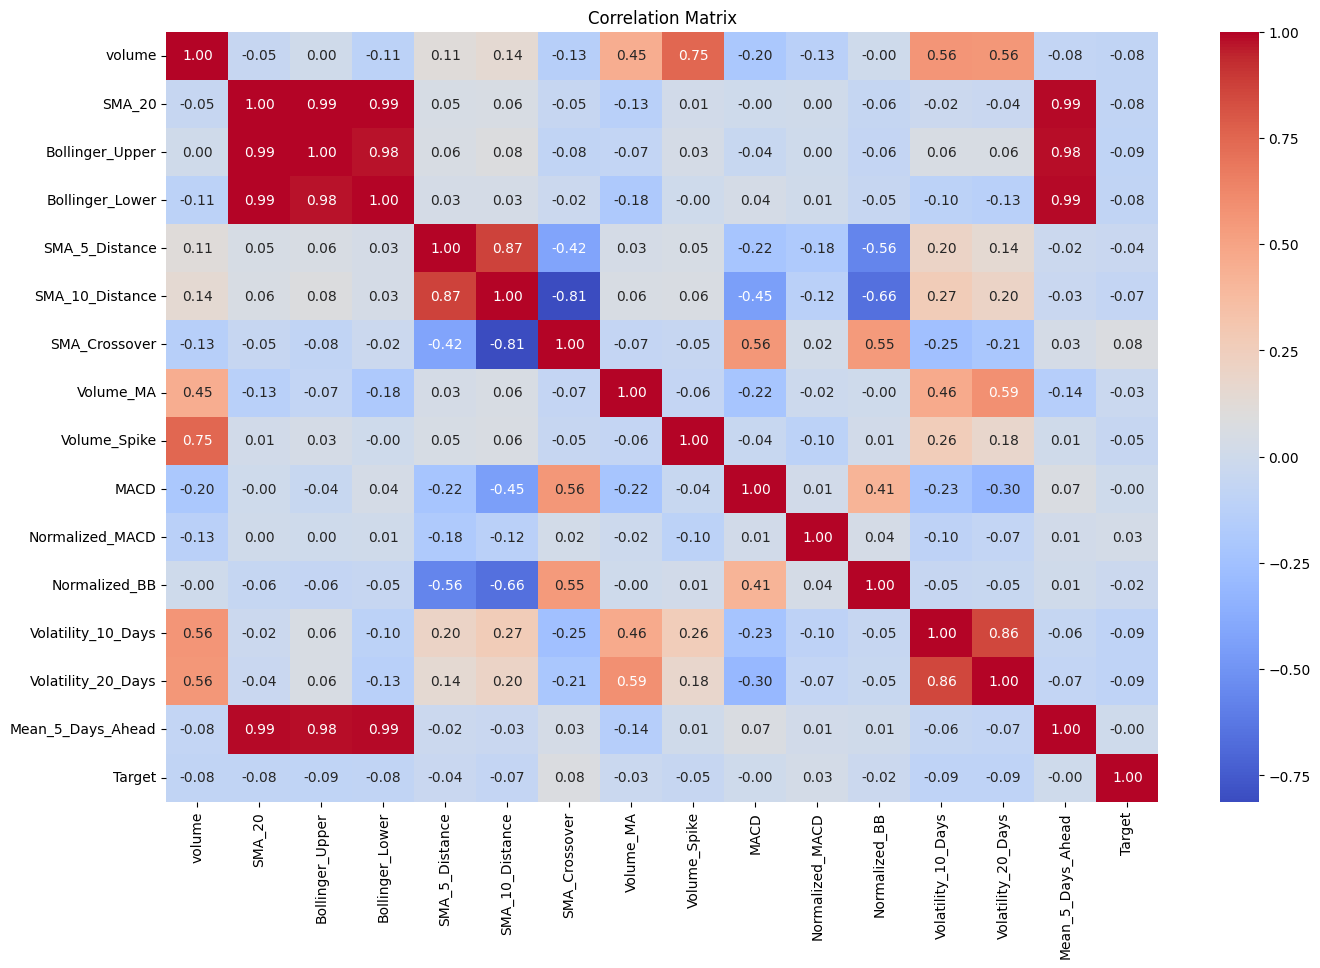

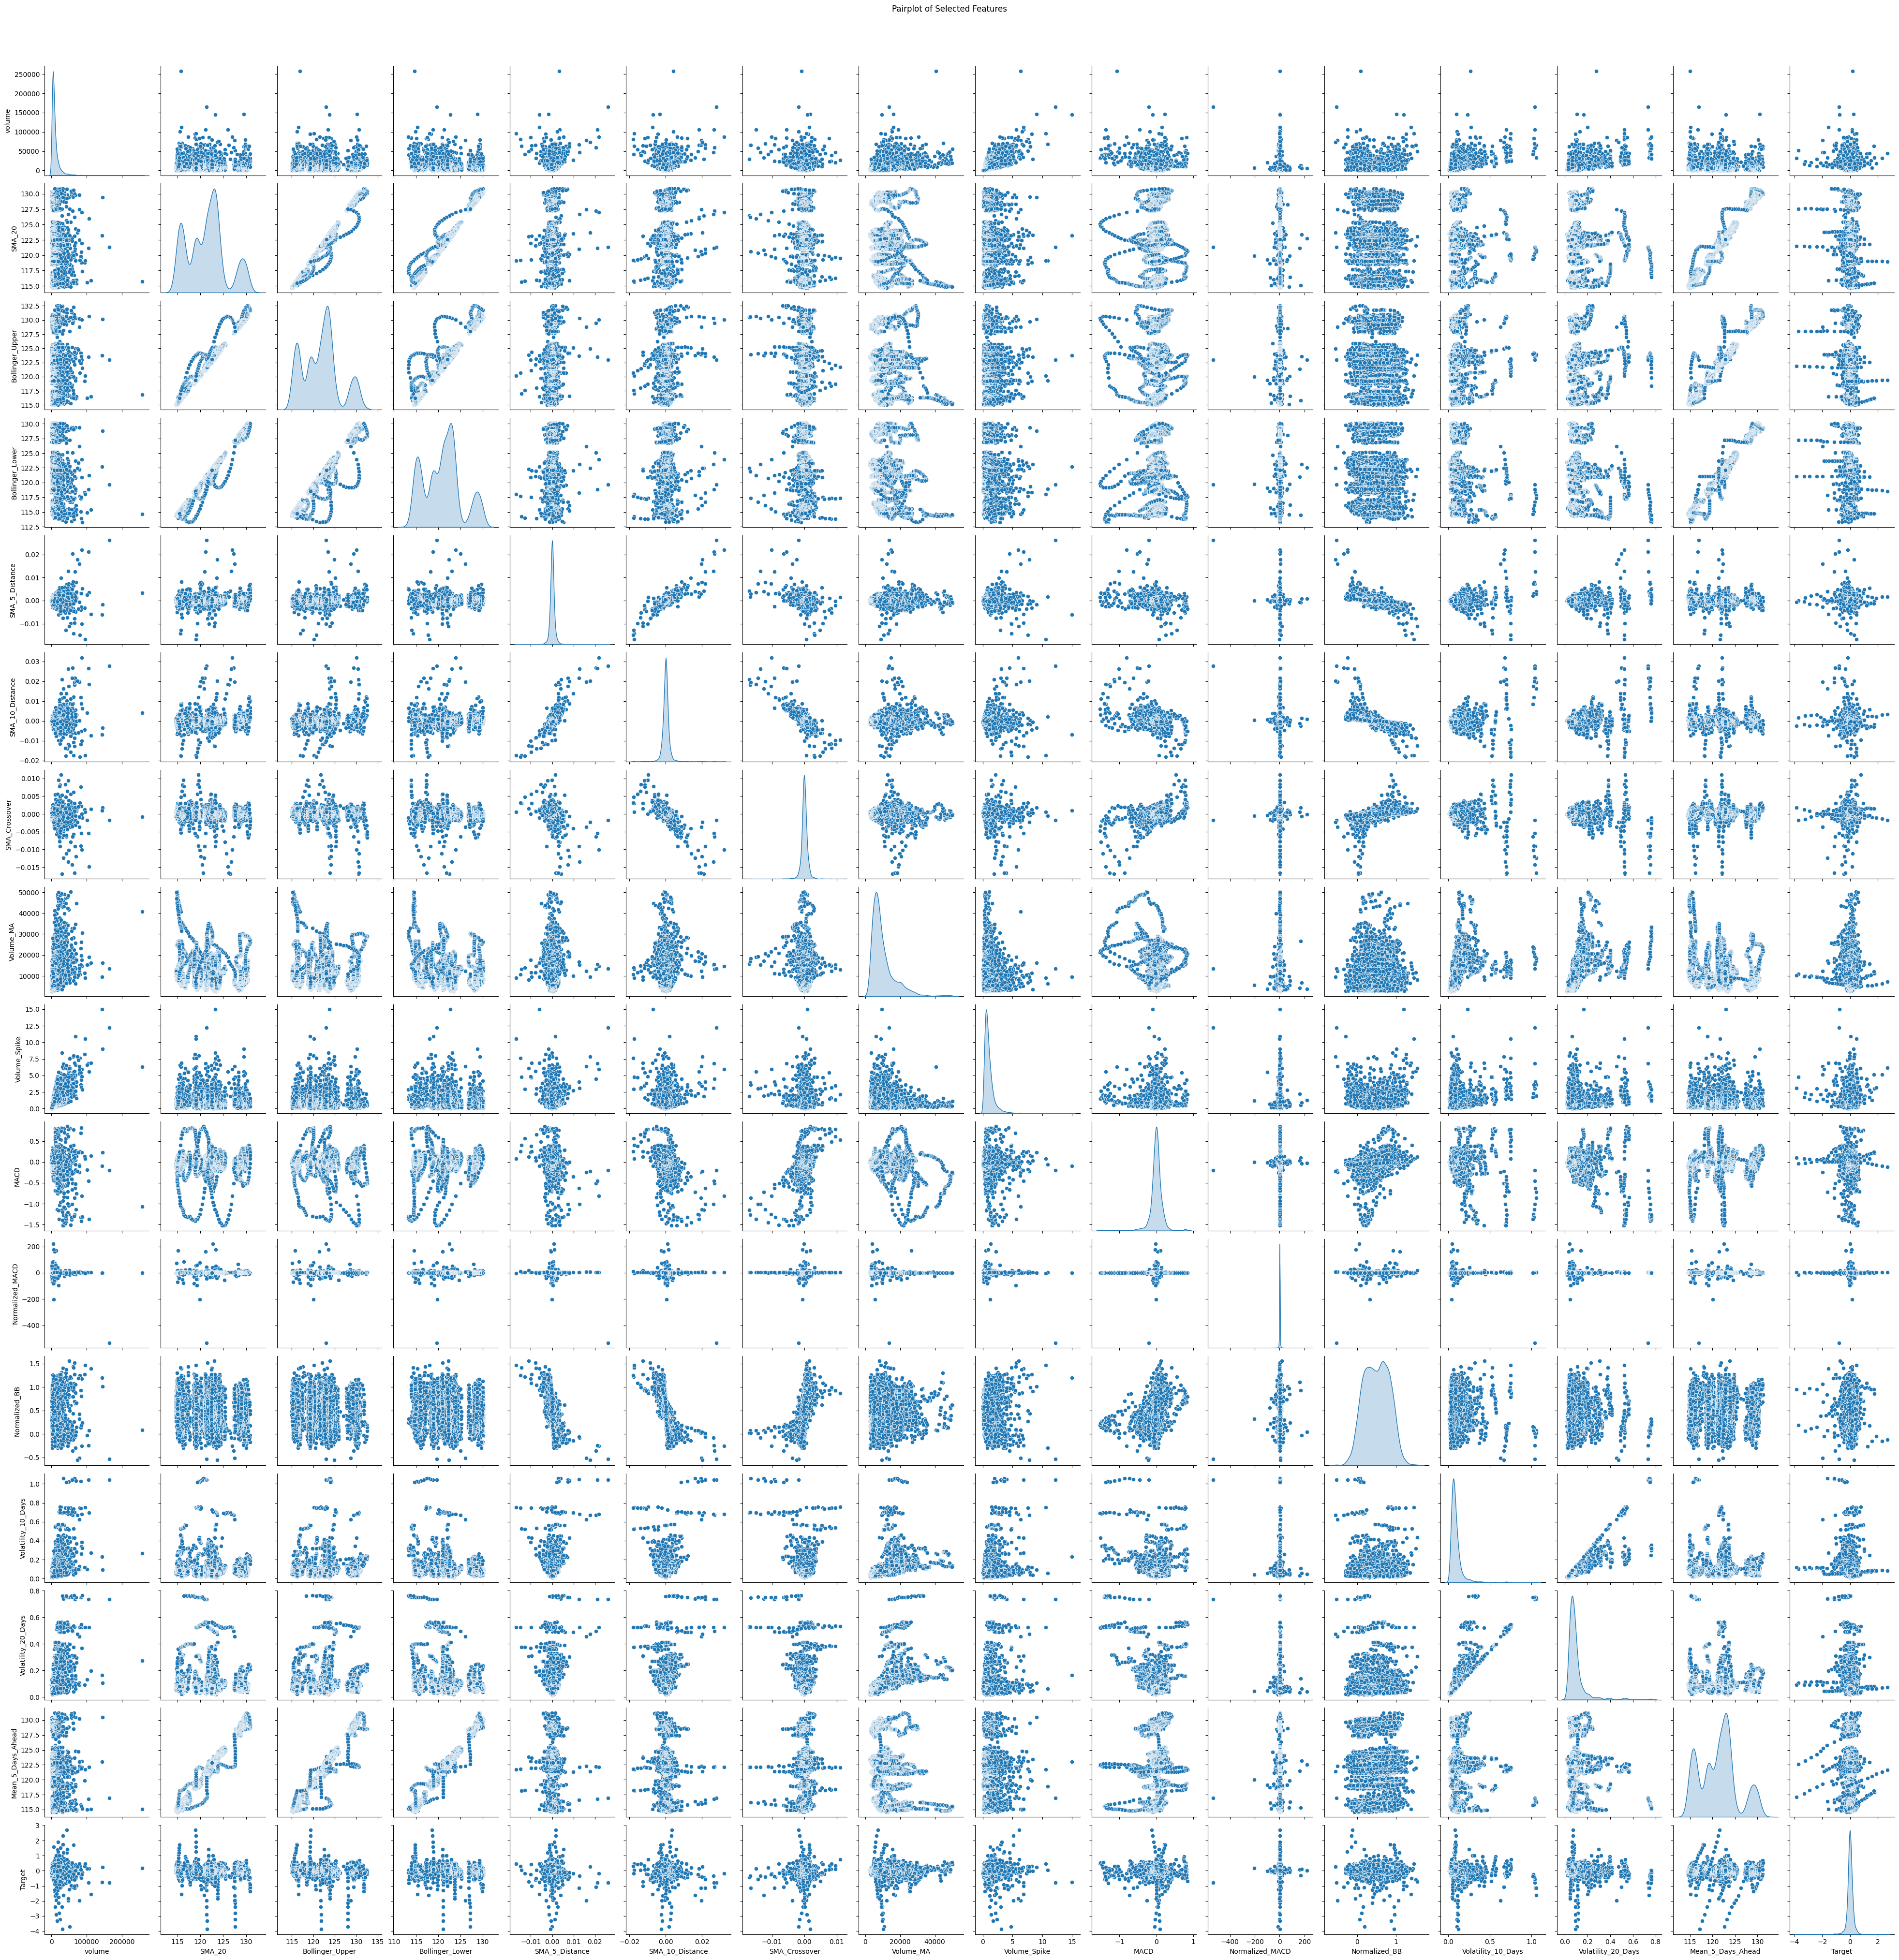

In [52]:
correlation_matrix = df.corr()

plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Wybór cech, w tym Target
selected_features = df.columns  # Możesz tu podać listę np. ['feature1', 'feature2', 'Target']
pairplot_data = df[selected_features]

# Tworzenie pairplotu
sns.pairplot(pairplot_data, diag_kind='kde', kind='scatter', height=2.5)
plt.suptitle('Pairplot of Selected Features', y=1.02)  # Dodatkowy tytuł
plt.show()


In [4]:
from scipy.stats import spearmanr

correlations = {}
for col in df.columns:
    if col != 'Target':
        correlations[col] = spearmanr(df[col], df['Target'])[0]

correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
print(correlations)

[('Bollinger_Upper', np.float64(-0.08598432246581718)), ('Bollinger_Lower', np.float64(-0.07913540060888405)), ('SMA_50_Distance', np.float64(0.043480013964392834)), ('MACD', np.float64(-0.04107240894704742)), ('SMA_Crossover', np.float64(-0.03782789422147942)), ('SMA_20_Distance', np.float64(0.03300597791597336)), ('Normalized_BB', np.float64(-0.03254779041274975)), ('Volatility_10_Days', np.float64(-0.021018961768037202)), ('Normalized_MACD', np.float64(0.019305027220010103)), ('Volume_MA', np.float64(0.010681637613650149)), ('Volatility_20_Days', np.float64(-0.008482596060077443)), ('volume', np.float64(0.007396474906586666)), ('Mean_5_Days_Ahead', np.float64(-0.007285380987627949)), ('Volume_Spike', np.float64(-0.00021242355254493832))]


In [5]:
from scipy.stats import pointbiserialr

correlation_results = {}
for column in df.drop(columns=['Target']).columns:
    correlation, p_value = pointbiserialr(df[column], df['Target'])
    correlation_results[column] = correlation

# Posortuj wyniki według korelacji
sorted_results = sorted(correlation_results.items(), key=lambda x: abs(x[1]), reverse=True)
print("Point-biserial Correlation Results:")
print(sorted_results)


Point-biserial Correlation Results:
[('Volatility_10_Days', np.float64(-0.09499039840050084)), ('Volatility_20_Days', np.float64(-0.09134149038487194)), ('Bollinger_Upper', np.float64(-0.08665062477391018)), ('volume', np.float64(-0.07781475523184958)), ('Bollinger_Lower', np.float64(-0.07619115191030579)), ('Volume_Spike', np.float64(-0.04989676002045518)), ('SMA_20_Distance', np.float64(-0.04185334476175892)), ('Normalized_MACD', np.float64(0.03004513980476854)), ('Volume_MA', np.float64(-0.027846709405205915)), ('SMA_50_Distance', np.float64(-0.021767307516051014)), ('Normalized_BB', np.float64(-0.021704459532433076)), ('SMA_Crossover', np.float64(-0.006920662729460927)), ('MACD', np.float64(-0.0038945210830148846)), ('Mean_5_Days_Ahead', np.float64(-0.002254683408605353))]


In [65]:
# Wanted data
#wanted_features = ['volume', 'Bollinger_Upper', 'Bollinger_Lower', 'SMA_20_Distance', 'SMA_50_Distance', 'SMA_Crossover', 'Volume_Spike', 'Normalized_MACD', 'Normalized_BB', 'Volatility_10_Days', 'Volatility_20_Days', 'Mean_5_Days_Ahead', 'Target']
#wanted_features = ['Bollinger_Upper', 'Bollinger_Lower', 'Target']
#wanted_features = ['Normalized_MACD', 'Normalized_BB', 'Target']
#wanted_features = ['SMA_20_Distance', 'SMA_50_Distance', 'Target']
#wanted_features = ['Normalized_MACD' , 'Target']
#wanted_features = ['Volatility_10_Days', 'Volatility_20_Days', 'Target']
#wanted_features = ['MACD_Signal', 'RSI_14', 'Target']
#wanted_features = ['SMA_Crossover', 'SMA_5_Distance', 'SMA_10_Distance' , 'Target'] #OK
wanted_features = ['Volatility_10_Days', 'Volatility_20_Days', 'Normalized_MACD', 'SMA_Crossover', 'SMA_10_Distance','Target'] #OK
#wanted_features = ['SMA_20_Distance', 'SMA_50_Distance', 'SMA_Crossover', 'Volume_Spike', 'Normalized_MAized_BB', 'Target']
#wanted_features = ['SMA_20_Distance', 'SMA_50_Distance', 'SMA_Crossover', 'Target']
#wanted_features = ['Bollinger_Upper', 'Bollinger_Lower', 'Volatility_10_Days', 'Volatility_20_Days', 'Target']
#wanted_features = ['MACD', 'Normalized_MACD', 'Volatility_10_Days', 'Volatility_20_Days', 'Target']
#wanted_features = ['Bollinger_Upper', 'Bollinger_Lower', 'Volume_Spike', 'Target']  #BEST
#wanted_features = ['SMA_20_Distance', 'SMA_50_Distance', 'Bollinger_Upper', 'Bollinger_Lower', 'Target']
#wanted_features = ['Normalized_MACD', 'Normalized_BB', 'Target']
#wanted_features = ['Volume_Spike', 'Volume_MA', 'Target']
#wanted_features = ['Volatility_10_Days', 'Volatility_20_Days', 'MACD', 'Target']
#wanted_features = ['SMA_Crossover', 'Target']       # Best for XGBoost
#wanted_features = ['Volatility_10_Days', 'Volatility_20_Days', 'SMA_20_Distance', 'SMA_50_Distance', 'Bollinger_Upper', 'Bollinger_Lower', 'Volume_Spike' , 'Target']
data = df[wanted_features]

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler

# Function to remove outliers using Z-score method
def remove_outliers_zscore(data, column, threshold=3):
    # Calculate Z-scores for the column
    z_scores = zscore(data[column])
    
    # Remove rows where the absolute Z-score is greater than the threshold
    data_cleaned = data[np.abs(z_scores) <= threshold]
    
    return data_cleaned

# Function to normalize the data (including 'Target' column)
def normalize_data(data, target_column='Target'):
    scaler = StandardScaler()
    
    # Normalize the features
    features = data.drop(columns=[target_column])
    features_scaled = scaler.fit_transform(features)
    
    # Normalize the target column
    target_scaled = scaler.fit_transform(data[[target_column]])
    
    # Recreate the DataFrame with normalized features and target
    data_normalized = pd.DataFrame(features_scaled, columns=features.columns)
    data_normalized[target_column] = target_scaled  # Add the normalized target column
    
    return data_normalized

    
# Remove outliers from the target column using Z-score method
data = remove_outliers_zscore(data, 'Target', threshold=3)
    
# Normalize the data (including target column)
data_normalized = normalize_data(data, 'Target')

# sns.pairplot(data_normalized)
# plt.show()


In [67]:
data_normalized.to_csv('../../data/reg_dataset.csv', index=False)

We Will do PCA, to get best vectors out of this data:

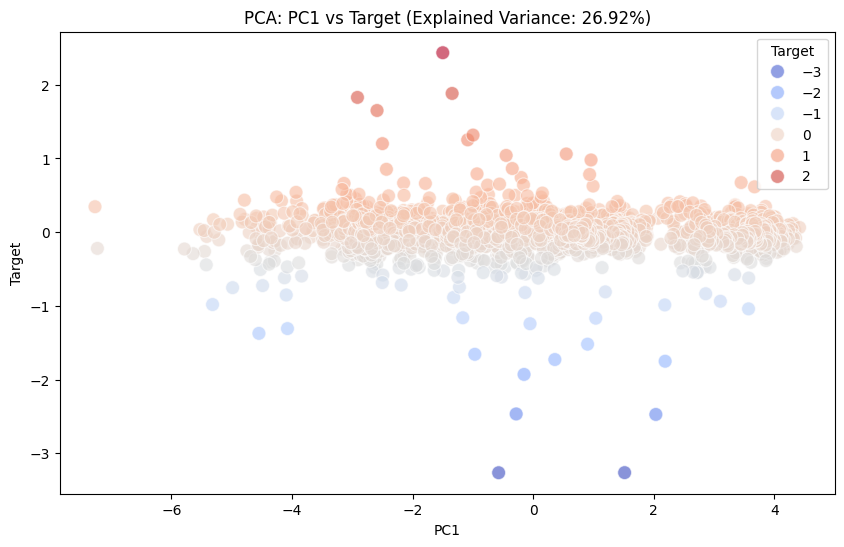

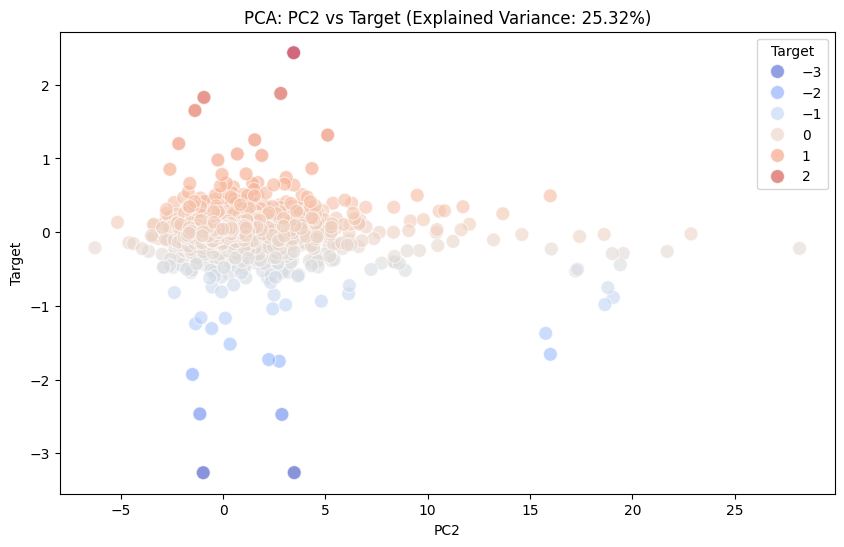

Explained Variance by each component: PC1: 26.92%, PC2: 25.32%


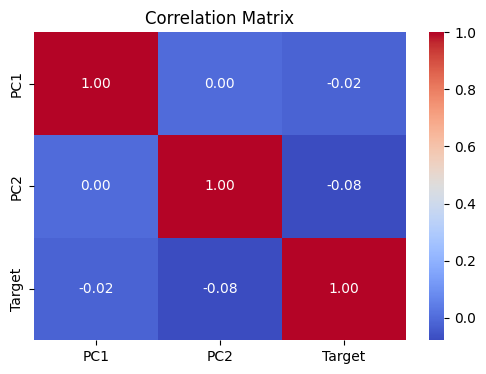

In [44]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Wybór cech, które chcesz uwzględnić w PCA
features = df.drop(columns=['Target'])  

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pca = PCA(n_components=2) 
pca_components = pca.fit_transform(features_scaled)

df_pca = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])

explained_variance = pca.explained_variance_ratio_

df_pca['Target'] = df['Target'].values  # Dodajemy Target, żeby sprawdzić jego zależność

# Wykres 1: PC1 vs Target
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['Target'], hue=df_pca['Target'], palette='coolwarm', s=100, alpha=0.6)
plt.title(f"PCA: PC1 vs Target (Explained Variance: {explained_variance[0]*100:.2f}%)")
plt.xlabel("PC1")
plt.ylabel("Target")
plt.legend(title='Target', loc='best')
plt.show()

# Wykres 2: PC2 vs Target
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca['PC2'], y=df_pca['Target'], hue=df_pca['Target'], palette='coolwarm', s=100, alpha=0.6)
plt.title(f"PCA: PC2 vs Target (Explained Variance: {explained_variance[1]*100:.2f}%)")
plt.xlabel("PC2")
plt.ylabel("Target")
plt.legend(title='Target', loc='best')
plt.show()

# Wydrukowanie procentowej zmienności wyjaśnionej przez każdy komponent
print(f"Explained Variance by each component: PC1: {explained_variance[0]*100:.2f}%, PC2: {explained_variance[1]*100:.2f}%")

correlation_matrix = df_pca.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()
